In [1]:
!ls

data.zip  gts_dataset.py  models.py  sample_data  utils.py


In [2]:
!unzip data.zip #Descomprime la carpeta

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: data/test_prepared/06646.png  
 extracting: data/test_prepared/08013.png  
 extracting: data/test_prepared/05006.png  
 extracting: data/test_prepared/01747.png  
 extracting: data/test_prepared/08006.png  
 extracting: data/test_prepared/03231.png  
 extracting: data/test_prepared/05240.png  
 extracting: data/test_prepared/03732.png  
 extracting: data/test_prepared/09868.png  
 extracting: data/test_prepared/05120.png  
 extracting: data/test_prepared/12523.png  
 extracting: data/test_prepared/10590.png  
 extracting: data/test_prepared/11227.png  
 extracting: data/test_prepared/04026.png  
 extracting: data/test_prepared/06894.png  
 extracting: data/test_prepared/06080.png  
 extracting: data/test_prepared/12147.png  
 extracting: data/test_prepared/07862.png  
 extracting: data/test_prepared/11371.png  
 extracting: data/test_prepared/02423.png  
 extracting: data/test_prepared/09561.png  
 extracting: da

#  Práctica Obligatoria - Parte II - MLP

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">MLPs</p>***

En esta parte, entrenarás varias redes MLPs y analizarás sus resultados en el dataset GTS.


### Evaluación - 3/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.25 puntos.
- **[Ejercicio 2]** 0.25 puntos.
- **[Ejercicio 3]** 0.5 puntos.
- **[Ejercicio 4]** 1 punto.
- **[Ejercicio 5]** 0.5 puntos.
- **[Ejercicio 6]** 0.5 puntos.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import SGD
from torch.optim import Adam

from gts_dataset import GTS


## Carga German Traffic Signs (GTS) dataset

Carga GTS en sus tres partes, como en el notebook anterior.

In [4]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)


### **[Ejercicio 1]** Crear una `MLP` con una única capa oculta

In [5]:
################ COMPLETAR #################
# Red neuronal MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model= nn.Sequential(nn.Flatten(1,-1),
                                  nn.Linear(input_size, hidden_size),
                                  nn.ReLU(),
                                  nn.Linear(hidden_size, output_size))
    def forward(self, x):
        return self.model(x)
############## Fin COMPLETAR ###############

### **[Ejercicio 2]** Crea una función que cuente el número de parámetros entrenables de un modelo


Instancia el modelo `MLP` que has creado antes y configúralo para que no tenga más de **200.000** parámetros:

In [6]:
################ COMPLETAR #################
def count_trainable_params(model: nn.Module) -> int:
    """
    Cuenta cuántos parámetros del modelo se pueden entrenar.

    Args:
        model (nn.Module): El modelo de PyTorch que queremos analizar.

    Returns:
        int: La cantidad de parámetros entrenables.
    """
    total_params = 0
    for p in model.parameters():
            if p.requires_grad:
                total_params += p.numel() #cuenta num elementos de un tensor
    return total_params

############## Fin COMPLETAR ###############


In [7]:
image, id = train_dataset[0]
c, w, h= image.shape

In [8]:
################ COMPLETAR #################
input_dim= c*w*h

output_dim= 43
hidden_dim= 104

model = MLP(input_dim, hidden_dim, output_dim)

trainable_params = count_trainable_params(model)
print(f"Número de parámetros entrenables: {trainable_params}")
############## Fin COMPLETAR ###############

Número de parámetros entrenables: 199619


### **[Ejercicio 3]** Crea las funciones de apoyo para el entrenamiento

Durante el entrenamiento, debes guardas las pérdidas de entrenamiento y validación para, posteriormente, graficarlas.

Para ello, guárdalas en un archivo `train_loss_mlp.csv` y otro `valid_loss_mlp.csv`.

Haz lo mismo para los *accuracies* `train_accuracy_mlp.csv` y `valid_accuracy_mlp.csv`.

In [9]:
################ COMPLETAR #################
# Función de entrenamiento
def train(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss =loss_fn(outputs, labels)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcular la precisión

        predicted = torch.argmax(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy
############## Fin COMPLETAR ###############

################ COMPLETAR #################
# Función de evaluación
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels =images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss =loss_fn(outputs, labels)

            running_loss += loss.item()

            # Calcular la precisión
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy
############## Fin COMPLETAR ###############

################ COMPLETAR #################
# Función para entrenar y evaluar, guardando las pérdidas y precisiones en archivos CSV
def train_and_evaluate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=10, test_loader=None, name='None'):
    train_losses = []
    val_losses = []
    train_accuracies = []  # Lista para almacenar las precisiones de entrenamiento
    val_accuracies = []  # Lista para almacenar las precisiones de validación

    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss, train_accuracy =  train(model, train_loader, loss_fn, optimizer, device)
        # COMPLETAR

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluación en el conjunto de validación
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn, device)# COMPLETAR

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir pérdidas y precisión
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Guardar pérdidas y precisión en archivos CSV
    train_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Loss': train_losses, 'Train Accuracy': train_accuracies})
    val_loss_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Loss': val_losses, 'Validation Accuracy': val_accuracies})

    train_loss_df.to_csv(f'train_loss_{name}.csv', index=False)
    val_loss_df.to_csv(f'valid_loss_{name}.csv', index=False)

    # Evaluación en el conjunto de test (si se proporciona)
    if test_loader is not None:
        test_loss, test_accuracy =  evaluate(model, test_loader, loss_fn, device)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Guardar la precisión de test en un archivo CSV
        test_accuracy_df = pd.DataFrame({'Test Accuracy': [test_accuracy]})
        test_accuracy_df.to_csv(f'test_accuracy_{name}.csv', index=False)

    # Guardar las precisiones de entrenamiento y validación en archivos CSV
    train_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Train Accuracy': train_accuracies})
    val_accuracy_df = pd.DataFrame({'Epoch': range(1, num_epochs+1), 'Validation Accuracy': val_accuracies})

    train_accuracy_df.to_csv(f'train_accuracy_{name}.csv', index=False)
    val_accuracy_df.to_csv(f'valid_accuracy_{name}.csv', index=False)

    return train_loss_df, val_loss_df, test_loss, test_accuracy
############## Fin COMPLETAR ###############


### **[Ejercicio 4]** Entrena el modelo solo 10 épocas.

Puedes hacer uso de la `gpu`, aunque no es necesario. De manera orientativa, 10 épocas en `cpu` deberían tardar menos de 90 segundos.

Para ellos, crea los dataloaders e instancia el modelo sin sobrepasar los 200.000 parámetros.

Usa una función de pérdida apropiada y el optimizador que consideres.


In [10]:
device = 'cpu'
batch_size = 16

################ COMPLETAR #################
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#train_features, train_labels = next(iter(train_loader))
#print(train_features.shape)

In [11]:

model = MLP(input_dim, hidden_dim, output_dim).to(device)

loss_fn =nn.CrossEntropyLoss()
optimizer1 =SGD(model.parameters(), lr=0.02)
optimizer2= Adam(model.parameters(), lr= 0.001, weight_decay= 1e-4)
optimizer3 = torch.optim.Adagrad(model.parameters(), lr=0.01)
optimizer4 = torch.optim.NAdam(model.parameters(), lr=0.002)



num_epochs = 10

# Entrenar y evaluar el modelo
train_loss_df, val_loss_df, test_loss, test_accuracy =  train_and_evaluate(model, train_loader,
                                                                           valid_loader, loss_fn, optimizer2, device, num_epochs, test_loader, name= 'mlp')
  # COMPLETAR

############## Fin COMPLETAR ###############

Epoch [1/10], Train Loss: 2.3680, Train Accuracy: 0.3891, Validation Loss: 1.6637, Validation Accuracy: 0.5597
Epoch [2/10], Train Loss: 1.3299, Train Accuracy: 0.6470, Validation Loss: 1.1547, Validation Accuracy: 0.6763
Epoch [3/10], Train Loss: 0.9640, Train Accuracy: 0.7447, Validation Loss: 0.9164, Validation Accuracy: 0.7529
Epoch [4/10], Train Loss: 0.7786, Train Accuracy: 0.7969, Validation Loss: 0.7805, Validation Accuracy: 0.7908
Epoch [5/10], Train Loss: 0.6648, Train Accuracy: 0.8265, Validation Loss: 0.7042, Validation Accuracy: 0.8115
Epoch [6/10], Train Loss: 0.5887, Train Accuracy: 0.8484, Validation Loss: 0.6506, Validation Accuracy: 0.8244
Epoch [7/10], Train Loss: 0.5339, Train Accuracy: 0.8625, Validation Loss: 0.6232, Validation Accuracy: 0.8357
Epoch [8/10], Train Loss: 0.4912, Train Accuracy: 0.8749, Validation Loss: 0.5847, Validation Accuracy: 0.8476
Epoch [9/10], Train Loss: 0.4546, Train Accuracy: 0.8853, Validation Loss: 0.5584, Validation Accuracy: 0.8565
E

Guarda el modelo pytorch con ayuda de las siguientes funciones, lo necesitarás más adelante.

Guárdalo con el nombre `mlp.pth`.

In [12]:
def save_full_model(model, file_name):
    """
    Guarda el modelo completo, incluyendo la arquitectura y los pesos.

    Args:
        model: El modelo de PyTorch a guardar.
        file_name: El nombre del archivo donde se guardará el modelo.
    """
    torch.save(model, file_name)
    print(f"Modelo completo guardado como {file_name}")


def load_full_model(file_name):

    """
    Carga el modelo completo desde un archivo guardado.

    Args:
        file_name: El nombre del archivo del modelo guardado.

    Returns:
        model: El modelo cargado.
    """
    model = torch.load(file_name)
    print(f"Modelo cargado desde {file_name}")
    return model


################ COMPLETAR #################
file_name= 'mlp.pth'
save_full_model(model, file_name)



############## Fin COMPLETAR ###############

Modelo completo guardado como mlp.pth


### **[Ejercicio 5]** Carga los datos de 'loss' y 'accuracy' que has generado y pinta las gráficas

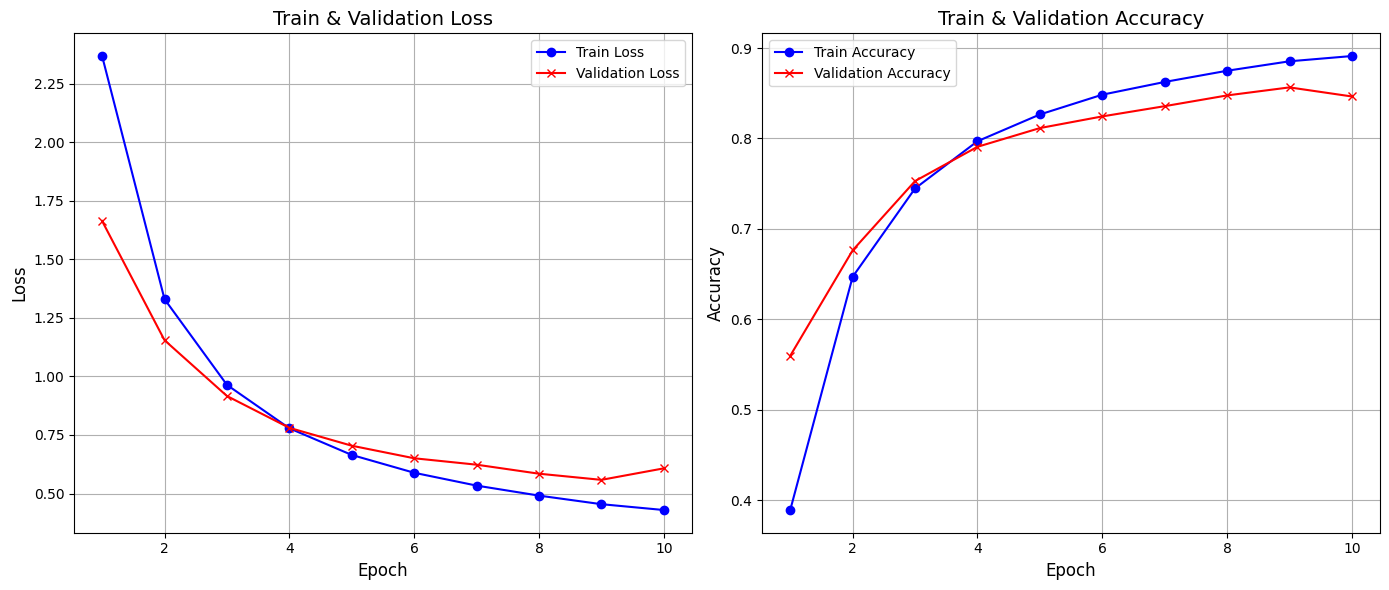

In [13]:
################ COMPLETAR #################

def plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file):
    # Leer los archivos CSV con los datos
    train_loss_df = pd.read_csv(train_loss_file)
    valid_loss_df = pd.read_csv(valid_loss_file)
    train_accuracy_df = pd.read_csv(train_accuracy_file)
    valid_accuracy_df = pd.read_csv(valid_accuracy_file)


    # Configuración de la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de las pérdidas
    ax1.plot(train_loss_df['Epoch'], train_loss_df['Train Loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
    ax1.plot(valid_loss_df['Epoch'], valid_loss_df['Validation Loss'], label='Validation Loss', color='red', linestyle='-', marker='x')
    ax1.set_title('Train & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Gráfico de las precisiones
    ax2.plot(train_accuracy_df['Epoch'], train_accuracy_df['Train Accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
    ax2.plot(valid_accuracy_df['Epoch'], valid_accuracy_df['Validation Accuracy'], label='Validation Accuracy', color='red', linestyle='-', marker='x')
    ax2.set_title('Train & Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

############## Fin COMPLETAR ###############


# Carga los datos y muéstralos
train_loss_file = 'train_loss_mlp.csv'
valid_loss_file = 'valid_loss_mlp.csv'
train_accuracy_file = 'train_accuracy_mlp.csv'
valid_accuracy_file = 'valid_accuracy_mlp.csv'

plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

### **[Ejercicio 6]** Calcula la matriz de confusión y el porcentaje de error por clase

Modelo cargado desde mlp.pth


<ipython-input-12-4fff1c810177>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(file_name)


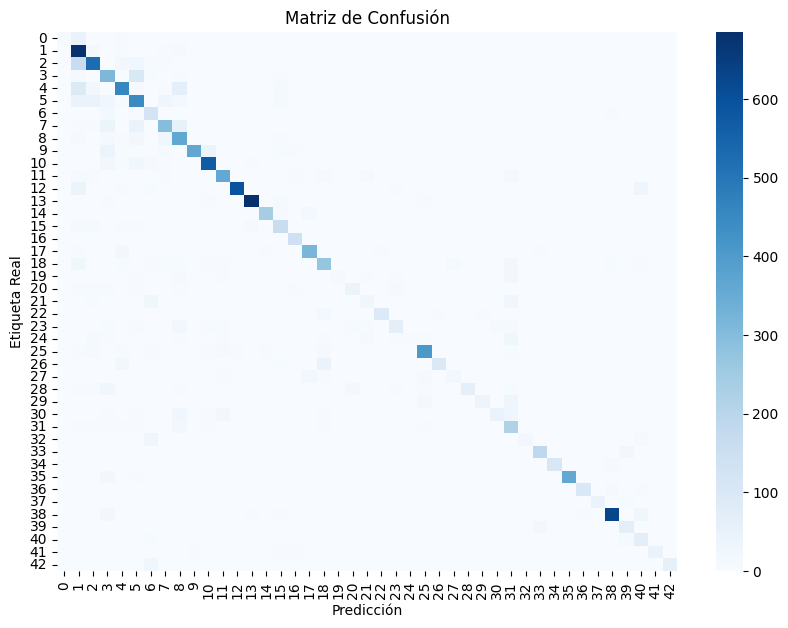

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

################ COMPLETAR #################

def plot_confusion_matrix(model, test_dataloader, device):
    """
    Genera y pinta la matriz de confusión de un modelo en PyTorch utilizando el DataLoader de prueba,
    y guarda la imagen resultante.

    Args:
        model: El modelo de PyTorch entrenado.
        test_dataloader: El DataLoader que contiene los datos de prueba.
        device: El dispositivo en el que se encuentra el modelo (CPU o GPU).
        filename: El nombre del archivo para guardar la imagen de la matriz de confusión.
    """
    # Poner el modelo en modo de evaluación
    model.eval()
            # COMPLETAR

    all_preds = []
    all_labels = []

    # Desactivar el cálculo de gradientes (no se necesita para la inferencia)
    with torch.no_grad():
        for images, labels in test_dataloader:
            # Enviar las imágenes y las etiquetas al dispositivo correcto
            images, labels =  images.to(device), labels.to(device) # COMPLETAR

            # Obtener las predicciones del modelo
            outputs = model(images) # COMPLETAR
            preds = torch.argmax(outputs, dim=1) # COMPLETAR

            # Almacenar las predicciones y las etiquetas reales
            all_preds.extend(preds.cpu().numpy())  # Convertir a CPU y luego a numpy
            all_labels.extend(labels.cpu().numpy())

    # Calcular la matriz de confusión
    cm =  confusion_matrix(all_labels, all_preds)  # COMPLETAR

    # Pintar la matriz de confusión usando seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

    return cm
############## Fin COMPLETAR ###############

model = load_full_model(file_name='mlp.pth')
cm = plot_confusion_matrix(model, test_loader, device=device)


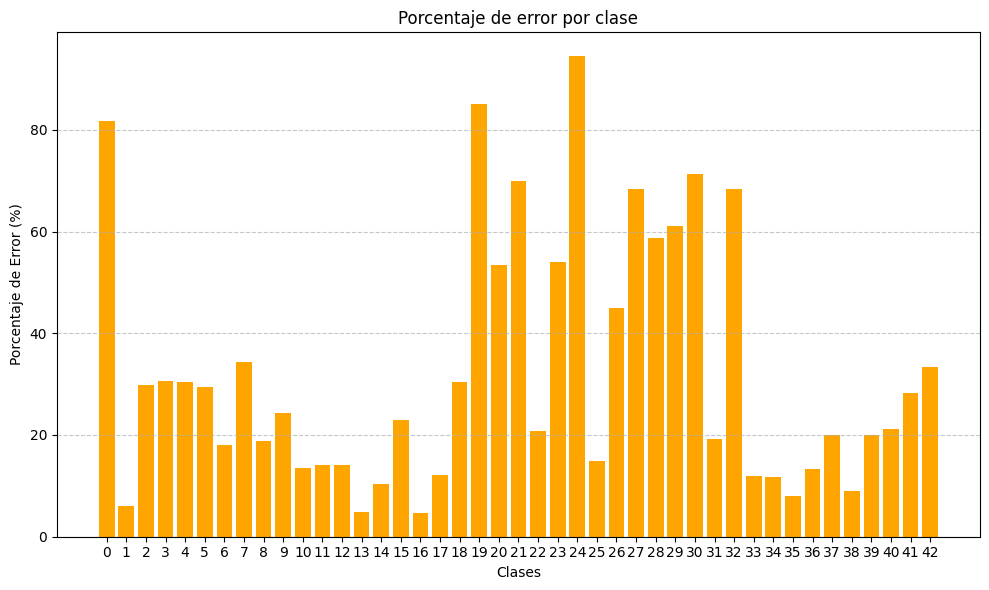

In [15]:
################ COMPLETAR #################

def plot_error_per_class(cm, title="Porcentaje de error por clase"):
    """
    Calcula y visualiza el porcentaje de error por clase a partir de la matriz de confusión.

    Args:
        cm (numpy.ndarray): Matriz de confusión (2D array).
        title (str): Título del gráfico.
    """
    # Calcular el porcentaje de error por clase
    total_per_class = cm.sum(axis=1)
    errors_per_class = total_per_class - np.diag(cm)
    error_per_class = errors_per_class / total_per_class

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(cm)), 100 * error_per_class, color='orange')
    plt.xlabel("Clases")
    plt.ylabel("Porcentaje de Error (%)")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(np.arange(len(cm)))
    plt.tight_layout()
    plt.show()
############## Fin COMPLETAR ###############

plot_error_per_class(cm)

## Guarda las funciones en un archivo llamado `utils.py`:

1. `count_trainable_params`
2. `train`
3. `evaluate`
4. `train_and_evaluate`
5. `save_full_model`
6. `load_full_model`
7. `plot_loss_accuracy`
8. `plot_confusion_matrix`
9. `plot_error_per_class`

## Guarda el modelo o modelos un archivo llamado `models.py`


---------------------